# Photometry and Fitting

Begin with the same photometry routine as `phot_multiexposures.ipynb`, which recovers the first few exposures before ingress that had different exposure times. 

This version of `phot_fit` is being written at Keck Observing HQ on Dec 14 in an attempt to come up with a new parameterization for the light curve that properly includes in the airmass as a multiplicative term.

In [1]:
%pylab inline
import pyfits
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import photPack2
from astropy.time import Time
import emcee

dophotometry = True
dofitting = False

Populating the interactive namespace from numpy and matplotlib


# Do photometry or load pre-calculated photometry

In [2]:
if dophotometry:
    print 'Calculating photometry'

    wasp6paths_nodsub_odd = ["%s%04d%s" % ('/local/tmp/mosfire/2014sep18_analysis/m140918_', \
                             i,'n_nobadpxl.fits') for i in range(365,629,1)]
    wasp6paths_sum_odd = ["%s%04d%s" % ('/local/tmp/mosfire/2014sep18_analysis/m140918_',\
                          i,'sum_nobadpxl.fits') for i in range(365,629,1)]
    testimgpath = wasp6paths_nodsub_odd[8]
    testimg = pyfits.getdata(testimgpath)
    arcpath = '/local/tmp/mosfire/2014sep18_analysis/m140918_0005shifted.fits'
    arcimage = pyfits.getdata(arcpath)
    wavelengthsoln = np.load('wavelengthsoln.npy')

    times = np.zeros(len(wasp6paths_nodsub_odd))
    fluxes = np.zeros((len(wasp6paths_nodsub_odd), 2))
    centroids = np.zeros((len(wasp6paths_nodsub_odd), 2))
    airmass = np.zeros(len(wasp6paths_nodsub_odd))

    targetbounds = [385, 445]
    compbounds = [1390, 1460]
    roughnodcentroids = [500, 1500] # Rough indices between A and B nods
    apertureradius = 18#20#8
    bg_o = 5      # Background box outer limit
    bg_i = 1.5#2.5    # Background box inner limit

    ### Preparing channelshift() and bad pixel detections from badpixelsearch.py
    rowlimits = [5, 2030]
    collimits = [5, 2044]
    bestshiftspath = '/local/tmp/mosfire/2014sep18_analysis/bestxshifts.npy'
    bestxshifts = np.load(bestshiftspath)
    oversamplefactor = 1
    def channelshift(image):
        ydim, xdim = image.shape
        outputpaddingwidth = np.ceil(np.max(bestxshifts)/oversamplefactor)
        outputpadding = np.zeros((ydim, outputpaddingwidth))
        paddedimage = np.hstack([outputpadding, image, outputpadding])

        for row in range(1, ydim):
            paddedimage[row] = np.roll(paddedimage[row], int(bestxshifts[row]/oversamplefactor))
        return paddedimage

    rowlimits = [5, 2030]
    collimits = [5, 2044]
    shapeimg = pyfits.getdata('/local/tmp/mosfire/2014sep18/m140918_0005.fits')[rowlimits[0]:rowlimits[1],collimits[0]:collimits[1]]

    def channelshift_coords(x,y,dims=np.shape(shapeimg)):
        image = np.zeros(dims)
        image[y,x] = 1
        ydim, xdim = image.shape
        outputpaddingwidth = np.ceil(np.max(bestxshifts)/oversamplefactor)
        outputpadding = np.zeros((ydim, outputpaddingwidth))
        paddedimage = np.hstack([outputpadding, image, outputpadding])

        for row in range(1, ydim):
            paddedimage[row] = np.roll(paddedimage[row], int(bestxshifts[row]/oversamplefactor))
        XX, YY = np.meshgrid(range(ydim),range(xdim))
        #coords = (XX[paddedimage == 1][0], YY[paddedimage == 1][0])
        coords = (np.arange(ydim)[np.sum(paddedimage,axis=0) == 1][0], np.arange(xdim)[np.sum(paddedimage,axis=1) == 1][0])
        return coords

    badpxls_x = []
    badpxls_y = []
    badpxls_exp = []
    for basepath in ['badpxlseven/','badpxlsodd/']:
        badpxls_x.append(np.array(map(float, open(basepath+'variablepxls_x.csv').read().splitlines())))
        badpxls_y.append(np.array(map(float, open(basepath+'variablepxls_y.csv').read().splitlines())))
        badpxls_exp.append(np.array(map(float, open(basepath+'variablepxls_exp.csv').read().splitlines())))
    # for basepath in ['badpxlsodd/','badpxlseven/']:
    #     badpxls_x = np.array(map(float, open(basepath+'variablepxls_x.csv').read().splitlines()))
    #     badpxls_y = np.array(map(float, open(basepath+'variablepxls_y.csv').read().splitlines()))
    #     badpxls_exp = np.array(map(float, open(basepath+'variablepxls_exp.csv').read().splitlines()))

    badpxls_x = np.concatenate(badpxls_x)
    badpxls_y = np.concatenate(badpxls_y)
    badpxls_exp = np.concatenate(badpxls_exp)
    meaningfulinds = badpxls_exp != 1e10
    badpxls_x = badpxls_x[meaningfulinds]
    badpxls_y = badpxls_y[meaningfulinds]
    badpxls_exp = badpxls_exp[meaningfulinds]

    #################################################################################

    ## Galaxy image
    galaxyimage = np.load('/astro/users/bmmorris/git/research/keck/2014september/analysis/rightnod/galaxy/wholeframegalaxyimg.npy')
    galaxyimagesum = np.load('/astro/users/bmmorris/git/research/keck/2014september/analysis/rightnod/galaxy/wholeframegalaxysum.npy')

    # Expected transit time:
    t0_expected = 2456918.887816  # JD
    t0_roughfit = 2456918.8793039066
    t14duration_expected = 0.1086 # days

    Nbins = 8
    paddingbounds = [210, 2130]
    spectralbinbounds = np.linspace(paddingbounds[0], paddingbounds[1], Nbins+1, dtype=int)

    times = np.zeros(len(wasp6paths_nodsub_odd))
    apertureradii = [28]#np.arange(20,40)#[39]#np.arange(30,45)#np.arange(10, 70, 5)#np.arange(14, 25, 2)
    chisquared_allbins = np.zeros(len(apertureradii),dtype=float)
    # Fluxes/errors dimensions: 
    # N time series, N stars, N spectral bins, N apertures
    fluxes = np.zeros((len(wasp6paths_nodsub_odd), 2, Nbins, len(apertureradii)))
    errors = np.zeros_like(fluxes)
    centroids = np.zeros((len(wasp6paths_nodsub_odd), 2))
    airmass = np.zeros(len(wasp6paths_nodsub_odd))
    wavelengthbincenters = np.zeros(Nbins)
    exposuredurs = np.zeros(len(wasp6paths_nodsub_odd))

    # Additional bad pixel correction in core of PSF: 
    badpxlmap = np.load('/astro/users/bmmorris/git/research/keck/2014september/analysis/rightnod/badpxlincoremap.npy')
    def correctbp(image, badpxlmap, plots=False, copyimage=True, medianwindow=3):
        props = {'cmap':cm.Greys_r, 'origin':'lower', 'vmin':-1.7e6, 'vmax':1.7e6, 'interpolation':'nearest'}
        dims = np.shape(badpxlmap)
        XX, YY = np.meshgrid(np.arange(dims[1]), np.arange(dims[0]))
        if copyimage:
            correctedimage = image.copy()
        else:
            correctedimage = image

        if plots:
            fig, ax = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)
            ax[0].imshow(image, **props)
            ax[0].plot(XX[badpxlmap], YY[badpxlmap], 'rx')

        for x, y in zip(XX[badpxlmap], YY[badpxlmap]):
            correctedimage[y, x] = np.median(np.concatenate([image[y, x-medianwindow:x], 
                                                             image[y, x+1:x+medianwindow]]))

        if plots:
            ax[1].imshow(correctedimage, **props)
            ax[1].plot(XX[badpxlmap], YY[badpxlmap], 'rx')
            plt.show(block=True)
        return correctedimage

    targetbounds = [385, 445]
    compbounds = [1390, 1460]
    roughnodcentroids = [500, 1500] # Rough indices between A and B nods
    #apertureradius = 18#20#8
    bg_o = 5      # Background box outer limit
    bg_i = 1.5#2.5    # Background box inner limit
    badpixelclip = 6.0 #sigma
    badpxlincore = 0
    #for i, imagepath in enumerate(wasp6paths_nodsub_odd[:1]):
    for i, imagepath, imagesumpath in zip(range(len(wasp6paths_nodsub_odd)), wasp6paths_nodsub_odd, wasp6paths_sum_odd):
        if i % 50 == 0: print i, 'of', len(wasp6paths_nodsub_odd)
        imagenameindex = int(imagepath.split('/')[-1].split('.')[0].split('_')[1].replace('n',''))
        image = pyfits.getdata(imagepath)#[:,paddingbounds[0]:paddingbounds[1]]
        header = pyfits.getheader(imagepath)
        imagesum = pyfits.getdata(imagesumpath)[:,paddingbounds[0]:paddingbounds[1]]
        times[i] = Time('2014-09-18 '+header['UTC'], scale='utc', format='iso').jd
        airmass[i] = header['AIRMASS']
        exposuredurs[i] = header['TRUITIME']


        ## Add in galaxy correction frame
        image += galaxyimage
        imagesum += galaxyimagesum[:,paddingbounds[0]:paddingbounds[1]]
        
        ## Check for bad pixels in this exposure
#         if imagenameindex in badpxls_exp:
#             correction_inds = badpxls_exp == imagenameindex

#             # Replace bad pixels with the median of the nearest 10 pixels in the channel
#             # if the median turns out to be within 2stddevs of the median of 
#             # the entire image: this will make sure not to correct bad pixels near the
#             # core of the PSF. 
#             oldimage = np.copy(image)
#             allmedian = np.median(image)
#             allstd = np.std(image)

#             for y_badpxl,x_badpxl in zip(badpxls_x[correction_inds], badpxls_y[correction_inds]):
#                 window = 10
#                 plotbadpxl = False
#                 if x_badpxl-window < 0:
#                     x_badpxl = window        # Correction January 13, 2015 
#                 windowmedian = np.median(image[x_badpxl-window:x_badpxl+window, y_badpxl])

#                 # windowmedian will return nan for pixels near the edges of images
#                 #print windowmedian, windowmedian, 0.5*allstd, imagepath
#                 if not np.isnan(windowmedian):
#                     #oldimage = np.copy(image)
#                     image[x_badpxl,y_badpxl] = windowmedian
#                     plotbadpxl = False
#                 elif np.isnan(windowmedian):
#                     plotbadpxl = False
#                 else: 
#                     badpxlincore += 1
#                     plotbadpxl = True

#                 if plotbadpxl:
#                     imgm = np.median(oldimage[x_badpxl-window:x_badpxl+window, y_badpxl-window:y_badpxl+window])
#                     imgstd = np.std(oldimage[x_badpxl-window:x_badpxl+window, y_badpxl-window:y_badpxl+window])
#                     imgN = 0.5
#                     fig, ax = plt.subplots(1,2,figsize=(14,8), sharex=True, sharey=True)
#                     ax[0].imshow(oldimage, interpolation='nearest', origin='lower', \
#                                  vmin=imgm-imgN*imgstd, vmax=imgm+imgN*imgstd)            #ys = np.arange(y_badpxl-window,y_badpxl+window)
#                     ax[1].imshow(image, interpolation='nearest', origin='lower', \
#                                  vmin=imgm-imgN*imgstd, vmax=imgm+imgN*imgstd)
#                     for axes in ax:
#                         axes.axvline(y_badpxl,lw=2,color='white')
#                         axes.axhline(x_badpxl,lw=2,color='white')
#                         axes.set_ylim([x_badpxl-window,x_badpxl+window])
#                         axes.set_xlim([y_badpxl-window,y_badpxl+window])
#                     plt.show()

        # crop image:
        image = correctbp(image, badpxlmap)[:,paddingbounds[0]:paddingbounds[1]]

        #image = image[:,paddingbounds[0]:paddingbounds[1]]

        for j in range(2):
            #target star is j=1
            leftcentroid, rightcentroid = photPack2.trackStar(image, [roughnodcentroids[j]-250,\
                                                               roughnodcentroids[j]+250], 0,\
                                                               plots=False, returnCentroidsOnly=True)
            if i % 2 == 0:
                centroids[i, j] = rightcentroid#leftcentroid
            else: 
                centroids[i, j] = leftcentroid

            for k in range(Nbins):
                binimage = image[:, spectralbinbounds[k]:spectralbinbounds[k+1]]
                binimagesum = imagesum[:, spectralbinbounds[k]:spectralbinbounds[k+1]]
                wavelengthbincenters[k] = np.mean([wavelengthsoln[spectralbinbounds[k]], wavelengthsoln[spectralbinbounds[k+1]]])
                #print leftcentroid, rightcentroid
                midnod = np.mean([leftcentroid, rightcentroid])
                for l, apertureradius in enumerate(apertureradii):
                    background_upper = binimage[centroids[i, j]+bg_i*apertureradius:centroids[i, j]+bg_o*apertureradius,:]
                    background_lower = binimage[centroids[i, j]-bg_o*apertureradius:centroids[i, j]-bg_i*apertureradius,:]
                    background = np.concatenate([background_upper, background_lower])#np.hstack([background_upper, background_lower])
                    meanbackground = np.mean(background)
                    rowprofile = np.sum(binimage[centroids[i, j]-10*apertureradius:centroids[i, j]+10*apertureradius,:],axis=1)
                    withinaperture = binimage[centroids[i, j]-apertureradius:centroids[i, j]+apertureradius,:]
                    withinaperture_sum = binimagesum[centroids[i, j]-apertureradius:centroids[i, j]+apertureradius,:]

                    withinaperture_corrected = np.copy(withinaperture)
                    medianwindow = 5
                    corr_x = []
                    corr_y = []
                    lastlength = 0
                    withinaperture = withinaperture_corrected

                    fluxes[i, j, k, l] = (np.sum(withinaperture) - meanbackground*withinaperture.size)/exposuredurs[i]
                    errors[i, j, k, l] = (np.sqrt(np.sum(withinaperture_sum) + meanbackground*withinaperture.size))/exposuredurs[i]
        #plt.plot(np.sum(image[leftcentroid-apertureradius:leftcentroid+apertureradius,:],axis=1))
    #plt.show()

    np.save('photoutputs_tmp/fluxes.npy', fluxes)
    np.save('photoutputs_tmp/errors.npy', errors)
    np.save('photoutputs_tmp/times.npy', times)
    np.save('photoutputs_tmp/airmass.npy', airmass)
    np.save('photoutputs_tmp/wavelengthbincenters.npy', wavelengthbincenters)
    np.save('photoutputs_tmp/exposuredurs.npy', exposuredurs)
else:
    print 'Loading pre-calculated photometry'
    fluxes = np.load('photoutputs_tmp/fluxes.npy')
    errors = np.load('photoutputs_tmp/errors.npy')
    times = np.load('photoutputs_tmp/times.npy')
    airmass = np.load('photoutputs_tmp/airmass.npy')
    wavelengthbincenters = np.load('photoutputs_tmp/wavelengthbincenters.npy')
    exposuredurs = np.load('photoutputs_tmp/exposuredurs.npy')


Calculating photometry
0 of 264
50 of 264
100 of 264
150 of 264
200 of 264
250 of 264


### Plot photometry

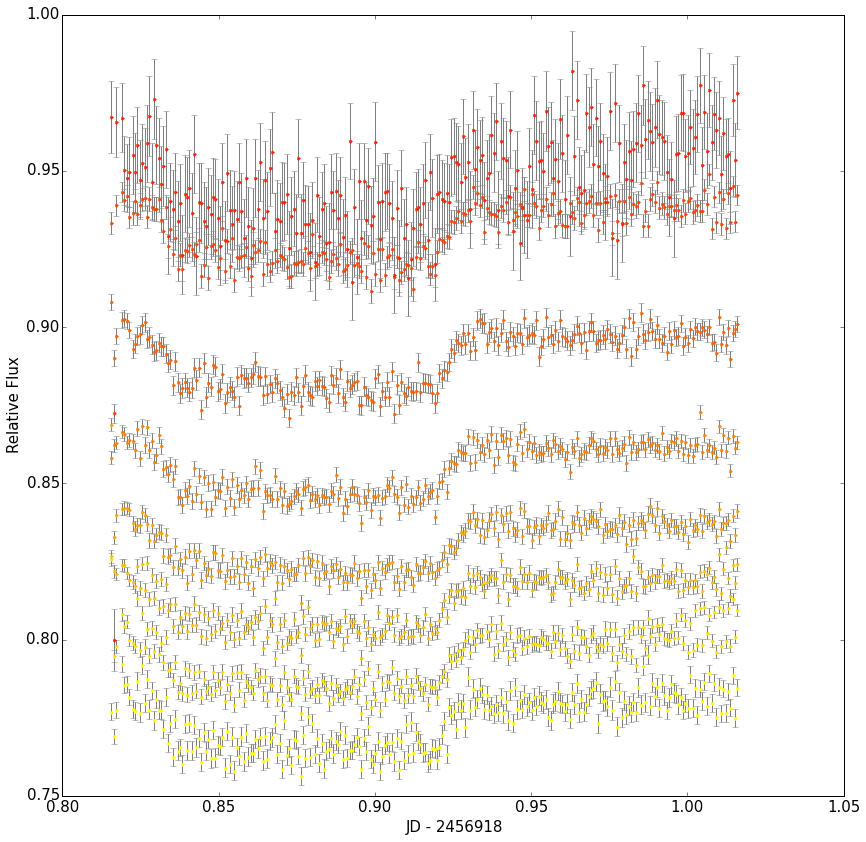

In [4]:
lightcurve = fluxes[:, 1, :, 0]/fluxes[:, 0, :, 0]
lightcurve_errors = lightcurve*np.sqrt((errors[:, 1, :, 0]/fluxes[:, 1, :, 0])**2 + (errors[:, 0, :, 0]/fluxes[:, 0, :, 0])**2)
Nbins = np.shape(lightcurve)[1]
#oot = (times < t0_roughfit - t14duration_expected/2.0) +      (times > t0_roughfit + t14duration_expected/2.0)
mintimeint = int(np.min(times))
cmap = plt.cm.autumn
fig, ax = plt.subplots(1, figsize=(14,14))
for eachbin in range(len(lightcurve[0,:])):
    ax.errorbar(times - mintimeint, lightcurve[:,eachbin] + eachbin*0.02, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax.set_xlabel('JD - %d' % mintimeint)
    ax.set_ylabel('Relative Flux')
    ax.grid()
plt.show()

# Set up MCMC fit

Parameters to **link**: $a/R_s,\; i, \; t_0, \; u_1, \; u_2$

Parameters to **float everywhere**: $R_p/R_s, \; F_0, \; c_X$

Parameters to **lock**: $P, \; e, \;\omega$

In [5]:
import sys
sys.path.append('/astro/users/bmmorris/Downloads/Fast_MA')
from ext_func.rsky import rsky
from ext_func.occultquad import occultquad
# def get_lc(aRs, i, t0, q1, q2, p0, F0, am, e, w, period, eps, t, airmassvector=airmass):
#     '''
#     e - eccentricity
#     aRs - "a over R-star"
#     i - inclination angle in radians
#     u1, u2 - quadratic limb-darkening coeffs
#     p0 - planet to star radius ratio
#     w - argument of periapse
#     period - period
#     t0 - midtransit (JD)
#     eps - minimum eccentricity for Kepler's equation
#     t - time array
#     '''
#     u1 = 2*np.sqrt(q1)*q2
#     u2 = np.sqrt(q1)*(1 - 2*q2)
#     r_s = 1.0
#     npoints = len(t)
#     #print e, aRs, i,u1, u2, p0, w, period
#     z0 = rsky(e, aRs, i, r_s, w, period, t0, eps, t)   #calculates separation of centers between the planet and the star
#     mu_c = occultquad(z0, u1, u2, p0, npoints)   #returns limb darkened model lightcurve
#     return (F0/am)*mu_c*(am + (airmassvector - 1))
def get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    e - eccentricity
    aRs - "a over R-star"
    i - inclination angle in radians
    u1, u2 - quadratic limb-darkening coeffs
    p0 - planet to star radius ratio
    w - argument of periapse
    period - period
    t0 - midtransit (JD)
    eps - minimum eccentricity for Kepler's equation
    t - time array
    '''
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    r_s = 1.0
    npoints = len(t)
    #print e, aRs, i,u1, u2, p0, w, period
    z0 = rsky(e, aRs, i, r_s, w, period, t0, eps, t)   #calculates separation of centers between the planet and the star
    mu_c = occultquad(z0, u1, u2, p0, npoints)   #returns limb darkened model lightcurve
    return F0*mu_c

from scipy import optimize
aOverRs = 1./0.0932 # Jord`an et al 2013
RpOverRs = 0.1404   # Jord`an et al 2013
eccentricity = 0
inclination = 88.47*np.pi/180
q1 = 0.00001
q2 = 0.2
periapse = np.pi/2
period = 3.361006
mineccentricity = 1.0e-7
t0_roughfit = 2456918.8793039066

Nbins = np.shape(lightcurve)[1]
print Nbins
# aRs, i, t0, RpRs, LD, F0, am
paramlimits = [[8.0, 14.0],  #aRs
               [85*np.pi/180, 95.0*np.pi/180],
               [np.min(times), np.max(times)],
               [0, 1.0], [0, 1.0]] +\
               Nbins*[[0.0, 0.3]] + \
               Nbins*[[0.1, 10]] + \
               Nbins*[[0.0, 9.0]]
#               Nbins*[[1.0, 1e3]]
lastp = 0

meantimediff = np.median(np.diff(times))
exptime = np.median(exposuredurs)/(60*60*24) # convert to units of days from seconds
def fine_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t, meantimediff=meantimediff):
    new_t = np.linspace(t.min() - 2*meantimediff, t.max() + 2*meantimediff, 5*len(t))
    return new_t, get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, new_t)

def binned_lc(aOverRs, inclination, t0_roughfit, q1, q2, RpOverRs, F0, am, eccentricity, 
              periapse, period, eps, t, airmassvector=airmass, exptime=exptime):
    new_t, finemodel = fine_lc(aOverRs, inclination, t0_roughfit, q1, q2, RpOverRs, 
                               F0, eccentricity, periapse, period, eps, t)
    timebinedges = np.sort(np.concatenate([t - 0.5*exptime, t + 0.5*exptime]))
    d = np.digitize(new_t, timebinedges)
    binned_model = np.array([np.mean(finemodel[d == i]) for i in range(1, 2*len(t), 2)])
    #return binned_model*(am + (airmassvector - 1))/am
    return binned_model*(1 + (airmassvector - 1)/am)

def genmodel(parameters, Nbins=Nbins):
    model = np.zeros_like(lightcurve)
    #ld_params = parameters[3+Nbins:3+4*Nbins].tolist()
    RpRs_params = parameters[5:5+Nbins]#.tolist()
    F0_params = parameters[5+Nbins:5+2*Nbins]#.tolist()
    am_params = np.exp(parameters[5+2*Nbins:])#.tolist()
    for eachbin in xrange(Nbins):
        #aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t
        lcparams = parameters[0:5].tolist() + \
                    [RpRs_params[eachbin], F0_params[eachbin], am_params[eachbin], eccentricity, \
                     periapse, period, 1e-7, times] # Fixed params
        #model[:,eachbin] = get_lc(*lcparams)
        #print lcparams
        model[:,eachbin] = binned_lc(*lcparams)
    return model

def lnlike(theta, x, y, yerr):
    model = genmodel(theta)
    return -0.5*(np.sum((y-model)**2/yerr**2))# - np.log(inv_sigma2)))

def lnprior(theta, paramlimits=paramlimits):
    parameters = theta
    # If parameter is locked, limits are set to [0,0]. If parameter is not locked,
    # check that all values for that parameter are within the set limits. If they are,
    # return 0.0, else return -np.inf
    for i, limits in enumerate(paramlimits):
        if not ((limits[0] < parameters[i]) and (parameters[i] < limits[1])):
            return -np.inf
    return 0.0

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


# #Describe initial fit parameters by hand 
# init_ld = Nbins*[0.2, 0.2]
# init_ld = [0.2, 0.2]
# init_RpRs = Nbins*[RpOverRs]
# init_F0 = (0.999*np.median(lightcurve, axis=0)).tolist()#Nbins*[0.9] 
# #init_am = Nbins*[50.0] 
# init_am = Nbins*[50.0] 
# initP = np.array([aOverRs, inclination, t0_roughfit] + init_ld + init_RpRs + init_F0 + init_am)


# Use previous fit parameters as the new intial parameters:
#initP = np.load('max_lnp_params_201412111513.npy')# np.load('max_lnp_params_201412111340.npy')#np.load('max_lnp_params.npy')
initP = np.load('max_lnp_params_201501131324.npy') # Begin with best fit from phot_fit-finetime.ipynb
#initP[-10:] = 50.00
#initP[-20:-10] *= 0.995
#initP[-Nbins:] = 6.2
labels = ['aRs', 'i', 't0'] + ['q1','q2'] + Nbins*['RpRs'] + Nbins*['F0'] + Nbins*['am']

for i, p in enumerate(initP):
    print labels[i], p
    
assert lnprior(initP) != -np.inf,'init condition does not satisfy priors'



8
aRs 11.7162310163
i 1.57467546379
t0 2456918.87855
q1 0.00465561970724
q2 0.603031176352
RpRs 0.137597124949
RpRs 0.133011443094
RpRs 0.134876028703
RpRs 0.132445051275
RpRs 0.129682534583
RpRs 0.148124535128
RpRs 0.141062934425
RpRs 0.135408556583
F0 0.779489621689
F0 0.773478453788
F0 0.778685354965
F0 0.774996306228
F0 0.778717765681
F0 0.797995468011
F0 0.817457143064
F0 0.811771597352
am 5.91226732215
am 4.03582267449
am 6.29587523647
am 5.40786033225
am 5.03636082271
am 8.15709173187
am 6.7569867546
am 5.65750573785


### Show initial parameters

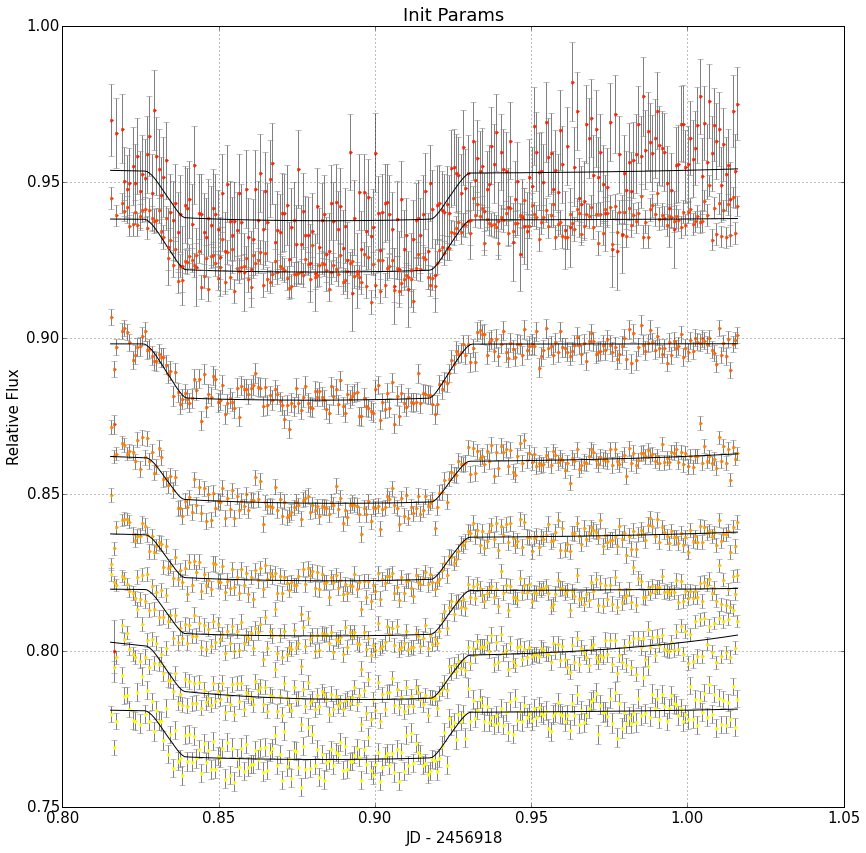

In [6]:
model = genmodel(initP)
fig, ax = plt.subplots(1, figsize=(14,14))
for eachbin in range(len(lightcurve[0,:])):
    ax.errorbar(times - mintimeint, lightcurve[:,eachbin] + eachbin*0.02, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax.plot(times - mintimeint, model[:,eachbin] + eachbin*0.02, 'k')
    ax.set_xlabel('JD - %d' % mintimeint)
    ax.set_ylabel('Relative Flux')
ax.grid()
ax.set_title('Init Params')
plt.show()

In [114]:
# print np.concatenate([1e-3*np.random.randn(len(initP[:-10])), 3*np.random.randn(len(initP[-10:]))])
# print [initP + np.concatenate([1e-3*np.random.randn(len(initP[:-10])), 
#        10*np.random.randn(len(initP[-10:]))]) for i in range(nwalkers)][0]

In [ ]:
Nfreeparameters = len(initP)

ndim = Nfreeparameters
nwalkers = 2*Nfreeparameters if 2*Nfreeparameters % 2 == 0 else 2*Nfreeparameters + 1

#pos = [initP + 1e-3*np.random.randn(len(initP)) for i in range(nwalkers)]
pos = [initP + np.concatenate([1e-4*np.random.randn(len(initP[:-Nbins])), 
       1e-1*np.random.randn(len(initP[-Nbins:]))]) for i in range(nwalkers)]
Nhours = 30
Nsteps = Nhours*2.7e3#1.8e3
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, \
          args=(times, lightcurve, lightcurve_errors))

print 'ndim =', ndim
print 'nwalkers =', nwalkers

print "Running initial burn in"
p0, _, _ = sampler.run_mcmc(pos, 50)
sampler.reset()

#pos = [p0[i] + 1e-2*np.random.randn(len(initP)) for i in range(nwalkers)]
print "Running production chains"
import datetime
print 'Start time:', datetime.datetime.now()

#p0, _, _ = sampler.run_mcmc(p0, Nsteps)
chainpath = '/local/tmp/mosfire/longchains/bpcorr2/'
f = open(chainpath+"chain.dat", "w") #iterations=500 -> 42 MB for raw text
f.write('#'+' '.join(labels)+'\n')
f.close()
for result in sampler.sample(p0, iterations=Nsteps, storechain=False):
    f = open(chainpath+"chain.dat", "a")
    for k in range(result[0].shape[0]):
        f.write("{0} {1} {2}\n".format(k, result[1][k], " ".join(map(str,result[0][k]))))
    f.close()
print 'End time:', datetime.datetime.now()

In [ ]:
burninfraction = 0.3
samples = sampler.chain[:, burninfraction*Nsteps:, :].reshape((-1, ndim))

#np.save('thirdchain20141210.npy', samples[::50,:])

import triangle

# trifig, ax = plt.subplots(Nfreeparameters, Nfreeparameters, figsize=(16, 16))
# fig2 = triangle.corner(samples[:, :], labels=labels, 
#                        fig=trifig, plot_datapoints=False) # truths=[t0_expected, aOverRs, RpOverRs, scale, 1]
# plt.show()

def medplusminus(vector):
    return map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(vector, [16, 50, 84])))

print np.shape(samples)
for i, l in enumerate(labels):#range(len(samples[0,:])):
    v = np.percentile(samples[:,i], [16, 50, 84])
    print l, v[1], v[2]-v[1], v[1]-v[0]

# for p, l in zip(lastp, labels):
#     print l, p

In [7]:
# model = genmodel(lastp)
# fig, ax = plt.subplots(1, figsize=(14,14))
# for eachbin in range(len(lightcurve[0,:])):
#     ax.errorbar(times - mintimeint, lightcurve[:,eachbin] + eachbin*0.02, \
#                 yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
#     ax.plot(times - mintimeint, model[:,eachbin])
#     ax.set_xlabel('JD - %d' % mintimeint)
#     ax.set_ylabel('Relative Flux')
#     ax.grid()
# plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(8,8))
Nhistbins = 50
sampleind = 10
n, edges = np.histogram(samples[:,sampleind], Nhistbins)
x = np.array([0.5*(edges[i] + edges[i+1]) for i in range(len(edges) - 1)])
x *= 180./np.pi if sampleind == 1 else 1.0

ax.plot(x, n)
ax.set_title(labels[sampleind])
plt.show()


In [ ]:
RpRs = samples[:,3:3+Nbins]
print np.shape(RpRs)
print np.median(RpRs, axis=0)#np.percentile(RpRs, 50, axis=0)

plt.plot(np.percentile(RpRs, 50, axis=0), color='k', lw=2)
plt.fill_between(range(Nbins),np.percentile(RpRs, 16, axis=0), np.percentile(RpRs, 84, axis=0), color='k', alpha=0.3)
plt.show()

In [ ]:
model = genmodel(np.mean(p0,axis=0))
fig, ax = plt.subplots(1, figsize=(14,14))
for eachbin in range(len(lightcurve[0,:])):
    ax.errorbar(times - mintimeint, lightcurve[:,eachbin] + eachbin*0.025, \
                yerr=lightcurve_errors[:,eachbin], fmt='.', color=cmap(1 - eachbin / float(Nbins)), ecolor='gray')
    ax.plot(times - mintimeint, model[:,eachbin]+ eachbin*0.025)
    ax.set_xlabel('JD - %d' % mintimeint)
    ax.set_ylabel('Relative Flux')
    ax.grid()
plt.show()

In [5]:
pwd

u'/astro/users/bmmorris/git/research/keck/2014september/analysis/bothnods'

In [27]:
#spectralbinbounds = np.linspace(paddingbounds[0], paddingbounds[1], Nbins+1, dtype=int)
#print spectralbinbounds

firstlines = \
'''
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
physical
'''

# Box format:
# centerx centery widthx widthy rot
with open('binregions.reg','w') as reg:
    for i in range(len(spectralbinbounds)-1):
        centerx =  0.5*(spectralbinbounds[i] + spectralbinbounds[i+1])
        centery = 2024/2
        widthx = spectralbinbounds[i+1] - spectralbinbounds[i]
        widthy = 2024
        angle = 0
        linewidth = 3
        wavelength = wavelengthbincenters[i]
        reg.write("box({0:f},{1:f},{2:f},{3:f},{4:f}) # width={5} text={{{6:.3f}}} \n".format(
                  centerx, centery, widthx, widthy, angle, linewidth, wavelength))